<a href="https://colab.research.google.com/github/SERVIR/flood_mapping_intercomparison/blob/main/notebooks/Module_8_Resampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

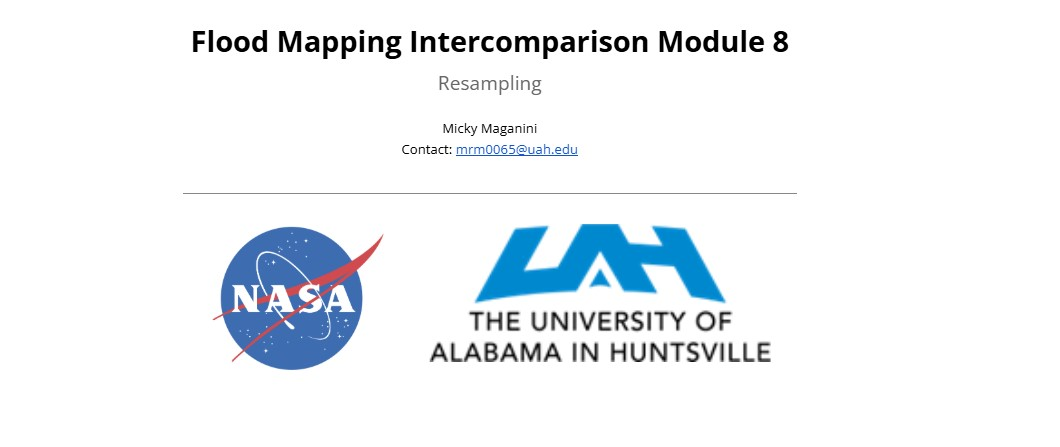

In this module, we will resample all of our products to a common pixel size. Since 4 of our 7 products already have a pixel size of 30 meters, we will use 30 meters as our common pixel size.

To accomplish this, we will use the gdal.Warp method. gdal.Warp takes the following optional arguments (among others):
* xRes
* yRes
* resampleAlg

Since we want to create square pixels measuring 30 meters by 30 meters in size, we will set xRes and yRes to both equal 30. The resampleAlg argument determines how the input map will go about determining the pixel value for each output 30x30m pixel. There are several options for this argument. In this case, we will use 'near', which is the nearest neighbor resampling algorithm. We will accomplish this by resampling the already harmonized maps that were a result of our processing in Module 3.

For more information on the different resampling algorithms available in GDAL, see [this page](https://gdal.org/en/stable/programs/gdalwarp.html) and scroll down to "-r resampling_method".

# Step 1: Import packages

In [ ]:
import ee
import geemap
from google.colab import drive
import os
import glob
from osgeo import gdal
import numpy as np
import pandas as pd
import time
from osgeo import gdal, osr

# MODIFIABLE VARIABLE ALERT

Change the variables below to match the needs of your case study.

In [ ]:
# Google Earth Engine folder. This should end in a slash.
my_gee_folder = "users/mickymags/sep_arkansas/"

# Google Earth Engine Project name
my_gee_project = 'servir-sco-assets'

# Google Drive Folder where your flood maps are located. This should end in a slash.
my_Gdrive_folder = "/content/drive/MyDrive/Flood_Intercomparison/Case_Studies/sep/sep_arkansas/"

# Flood event description. This can be whatever you want it to be
flood_event_desc = 'sep_arkansas'

In [ ]:
# Authenticate and initialize Earth Engine. This will kick off a pop-up window that you must click through.
ee.Authenticate()

ee.Initialize(project=my_gee_project)

In [ ]:
aoi = ee.FeatureCollection(my_gee_folder + "aoi")
roi = aoi.geometry()
aoi_centroid = aoi.geometry().centroid()             # Get the center of the AOI
lon = aoi_centroid.coordinates().get(0).getInfo()    # Extract the longitude from the centroid
lat = aoi_centroid.coordinates().get(1).getInfo()    # Extract the latitude from the centroid

# Step 2: Resample GFM, MCDWD, and VFM products (and maybe HYDROSAR)

In order to run object extraction statistics, we must have all products in a common projection. Thus, we will use gdal.Warp to resample these products to 30 meters

In [ ]:
# Mount Google Drive
drive.mount('/content/drive/')

In [ ]:
# Choose the Google Drive folder you defined in the MODIFIABLE VARIABLE section
os.chdir(my_Gdrive_folder)

## Step 2 Part 1: GFM

In [ ]:
os.chdir('GFM') # Choose the GFM directory

In [ ]:
infile = glob.glob('harmonized_gfm*')[0] # define the infile, which will be the input

In [ ]:
outfile = 'gfm_resampled_' + flood_event_desc + '.tif' # define the outfile string, which will be the output

In [ ]:
info = gdal.Info(infile)        # Get the info from the inflie
find = info.find('Data axis')   # find the index of the information containing the projection
proj = info[find-8:find-3]      # slice the info string to extract projection EPSG code
my_proj = 'EPSG:'+proj          # manipulaate EPSG code for formatting
print(my_proj)                  # print the projection

In [ ]:
# Resample the input file to 30x30m and write data to the output file
gdal.Warp(outfile, infile, dstSRS=my_proj, resampleAlg='near', xRes=30, yRes=30)

## Step 2 Part 2: MCDWD

Now let's repeat the above process for the MCDWD product

In [ ]:
os.chdir('../MCDWD')

In [ ]:
# Input file
mcdwd_infile = infile = glob.glob('harmonized_mcd*')[0]

In [ ]:
#Output file
mcdwd_outfile = 'mcdwd_intermediate_' + flood_event_desc + '.tif'

In [ ]:
# Resample infile to 30m x 30m at write it to the output file
gdal.Warp(mcdwd_outfile, mcdwd_infile, dstSRS=my_proj, resampleAlg='near', xRes=30, yRes=30)

In [ ]:
inter_mcdwd = mcdwd_outfile                               # Define intermediate file path
final_mcdwd = f'mcdwd_resampled_{flood_event_desc}.tif'   # Define string for final output file path
vector_mcdwd = glob.glob('drive_export*')[0]              # Define file path for area of interest

In [ ]:
# Clip the intermediate file to the area of interest,
gdal.Warp(
    final_mcdwd,                   # output
    inter_mcdwd,                   # input
    cutlineDSName=vector_mcdwd,    # area of interest input
    cropToCutline=True,            # boolean controlling clipping
    dstNodata = 2                  # value to use for no-data pixels
)

## Step 2 Part 3: VFM

Repeat the above steps for the VFM product

In [ ]:
os.chdir('../VFM') # Navigate to the VFM subdirectory

In [ ]:
vfm_infile = infile = glob.glob('harmonized_vfm*')[0]          # Input File

In [ ]:
vfm_outfile = 'vfm_intermediate_' + flood_event_desc + '.tif'  # Output File

In [ ]:
# Resample the input file to 30m x 30m and write to the output file
gdal.Warp(vfm_outfile, vfm_infile, dstSRS=my_proj, resampleAlg='near', xRes=30, yRes=30)

In [ ]:
inter_vfm = vfm_outfile                                # Intermediate file
final_vfm = f'vfm_resampled_{flood_event_desc}.tif'    # Final output file
vector_vfm = glob.glob('drive_export*')[0]             # file path to the area of interest

In [ ]:
# Warp output file
gdal.Warp(
    final_vfm,                   # Output
    inter_vfm,                   # Input
    cutlineDSName=vector_vfm,    # Area of interest
    cropToCutline=True,          # boolean controlling whether or not to clip
    dstNodata = 2                # value to use for no-data pixels
)

## Step 2 Part 4: HYDROSAR

In some cases, HYDROSAR will not have a pixel size of 30 meters. If it does not, we will undergo the same workflow we did for VFM, GFM, and MCDWD. Let's check the pixel size of HYDROSAR

In [ ]:
os.chdir('../HYDROSAR')    # choose the HYDROSAR directory

In [ ]:
hydrosar_infile = infile = glob.glob('harmonized_hydrosar*')[0]  # Define the path to the HYDROSAR input file

In [ ]:
# Open the HYDROSAR input file
hydrosar_file = gdal.Open(hydrosar_infile)

# get the pixel size of hydrafloods
hydrosar_pixel_size = hydrosar_file.GetGeoTransform()[1]

# Ask the computer to tell us whether or not we need to reproject HYDROSAR
if hydrosar_pixel_size == 30:
  print("HYDROSAR has a pixel size of 30 meters. Skip to step 3.")
else:
  print("HYDROSAR has a pixel size slightly different than 30 meters. Continue running the code below.")

In [ ]:
# Define hydrosar output file
hydrosar_outfile = 'hydrosar_resampled_' + flood_event_desc + '.tif'

In [ ]:
# Resample the input file to 30m x 30m and write to the output file
gdal.Warp(hydrosar_outfile, hydrosar_infile, dstSRS=my_proj, resampleAlg='near', xRes=30, yRes=30)

# (OPTIONAL) Step 3: Exporting to Google Earth Engine

Now all of our resampled flood maps are available in the Google Drive folder we designated at the beginning of this notebook. If you would like to run module 9, you must upload the resampled flood maps to Google Earth Engine. When doing so, make sure to change the pyramiding policy to Mode. You should upload all of the harmonized maps to Google Earth Engine in the same folder and with the name of "x_harmonized" (i.e. dswxhls_harmonized, gfm_harmonized)